# Economic analysis of the optimization results
This notebook is dedicated to the economic evluation of the optimization results produced using the "colab-summerschool_example_iesopt.ipynb" notebook.

# Adding the result files to this notebook

Please find the "opt.zip" folder on the TwinVECTOR Sharepoint on Teams in the folder "04_Supplementary Material". Use drag & drop to put it directly into the Colab file explorer (left sidebar). Since it is a folder, you have to unzip it first.

After unzipping, your folder will be inside `/content/`, with the same name as the zip file (without the .zip) unless the archive contains its own folder structure.

You can unzip "opt.zip" by removing the hash in front of the command line below and executing it.

In [1]:
# !unzip opt.zip

## Imports
First, the necessary python functionalities (packages) have to be imported.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

## Definition of reusable functions
In order to facilitate the economic analysis, we will define a set of functions that can be reused in the assessment and visualisation of each of our investigated BESS configurations (defined by a combination of battery power and capacity).

### Function to calculate economic KPIs
This function calculates three economic KPIs, namely the Net Present Value (NPV), the dynamic amortisation time, and the Return on Investment (ROI). For their definition, please refer to the summer school slides for the economic assessment.

In [3]:
def economic_kpis(df: pd.DataFrame,
                  discount_rate: float,
                  cash_col: str = "total_cashflow",
                  cost_col: str = "total_costs",
                  profit_col: str = "total_profits"
                  ) -> dict:
    """
    Calculate key economic KPIs from a time-series DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain at least the columns for cashflow, total_costs, total_profits.
        Index or a column should represent year 0..N (year-end).
    discount_rate : float
        Annual discount rate as a decimal (e.g. 0.08 for 8%).
    cash_col, cost_col, profit_col : str
        Column names for cash flow, total costs, and total profits.

    Returns
    -------
    dict
        {
          'NPV': float,
          'dynamic_amortisation_time': float,
          'ROI': float
        }
    """
    # Ensure numeric and correct ordering
    df = df.copy().reset_index(drop=True)
    years = np.arange(len(df))

    # --- NPV ---
    cashflows = df[cash_col].astype(float).values
    npv = np.sum(cashflows / (1 + discount_rate) ** years)

    # --- Dynamic Amortisation Time ---
    discounted_cum = np.cumsum(cashflows / (1 + discount_rate) ** years)
    if np.any(discounted_cum >= 0):
        # Find the first year where cumulative discounted cash flow turns positive
        year_positive = np.argmax(discounted_cum >= 0)
        if year_positive == 0:
            dynamic_amort = 0.0
        else:
            # Linear interpolation between the previous year and this year
            prev_val = discounted_cum[year_positive - 1]
            this_val = discounted_cum[year_positive]
            frac = -prev_val / (this_val - prev_val)
            dynamic_amort = (year_positive - 1) + frac
    else:
        dynamic_amort = np.nan  # never amortises within horizon

    # --- ROI ---
    total_profit = df[profit_col].sum()
    total_costs = df[cost_col].abs().sum()
    roi = (total_profit - total_costs) / total_costs if total_costs != 0 else np.nan

    return {
        "NPV": npv,
        "dynamic_amortisation_time": round(dynamic_amort),
        "ROI": roi
    }

### Function to create a heatmap plot
This function creates a heatmap plot of the results for each of the configurations with regards to the respective KPIs in order to compare the different configurations.

In [4]:
def kpi_heatmap(df: pd.DataFrame,
                kpi: str,
                cmap: str = "YlGnBu",
                decimals: int = 2,
                figsize: tuple = (8, 5)) -> None:
    """
    Create a heatmap of a chosen KPI across power vs. capacity_hrs.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns: 'power', 'capacity_hrs', and the KPI of interest.
    kpi : str
        One of 'NPV', 'ROI', or 'dynamic_amortisation_time'.
    """
    if kpi not in df.columns:
        raise ValueError(f"'{kpi}' column not found in DataFrame.")

    # Force numeric types for the KPI, power, and capacity columns
    df = df.copy()
    for col in ["power", "capacity_hrs", kpi]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Drop any rows with NaNs after conversion
    df = df.dropna(subset=["power", "capacity_hrs", kpi])

    # Pivot to matrix form
    pivot = df.pivot(index="capacity_hrs", columns="power", values=kpi)
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)

    plt.figure(figsize=figsize)
    sns.heatmap(
        pivot,
        annot=True,
        fmt=f".{decimals}f",
        cmap=cmap,
        cbar_kws={"label": kpi}
    )
    plt.title(f"{kpi} Heatmap")
    plt.xlabel("Power (MW)")
    plt.ylabel("Capacity (h)")
    plt.tight_layout()
    plt.show()

### Function to create a stacked bar plot
This function creates a stacked bar plot of the cashflow results for one of the configurations.

In [5]:
def stacked_profit_cost_bar(df: pd.DataFrame,
                            line_index: str = '2025-12-31',
                            figsize: tuple = (8, 6),
                            revenue_colors=("tab:green", "tab:blue"),
                            cost_colors=("tab:red", "tab:orange")) -> None:
    """
    Create a stacked bar plot for a given row in the dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
        ['electricity_profits_sell','avoided_costs_baseline',
         'electricity_costs_buy','opex_bess'].
        Index can be dates or strings convertible to match `line_index`.
    line_index : str = '2025-12-31'
        Index label (default '2025-12-31') to use for the bars.
    figsize : tuple
        Figure size (width, height).
    revenue_colors : tuple
        Colors for (electricity_profits_sell, avoided_costs_baseline).
    cost_colors : tuple
        Colors for (electricity_costs_buy, opex_bess).
    """
    # Ensure index is string-like for matching
    if line_index not in df.index.astype(str):
        raise ValueError(f"'{line_index}' not found in DataFrame index.")

    row = df.loc[line_index]

    # Values for the stacked bars
    revenues = [
        row["electricity_profits_sell"],
        row["avoided_costs_baseline"]
    ]
    costs = [
        - row["electricity_costs_buy"],
        - row["opex_bess"]
    ]

    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # --- Revenues bar ---
    bottom = 0
    for val, color, label in zip(revenues, revenue_colors,
                                 ["electricity_profits_sell", "avoided_costs_baseline"]):
        ax.bar("Revenues", val, bottom=bottom, color=color, label=label)
        bottom += val

    # --- Costs bar ---
    bottom = 0
    for val, color, label in zip(costs, cost_colors,
                                 ["electricity_costs_buy", "opex_bess"]):
        ax.bar("Costs", val, bottom=bottom, color=color, label=label)
        bottom += val

    ax.set_ylabel("Cashflow (€)")
    ax.set_title(f"Revenues vs. Costs for one year")
    ax.legend(title="Components", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


### Function that does the cost / profit calculations
This function calculates the individual cost and profit components, as well as the total costs, total profits, and total cashflow for a given BESS configuration.

In [10]:
def evaluate_profitability(power: float, cap_hrs: float, path: str = 'opt/out') -> pd.DataFrame:
    
    # Specifying the BESS configuration, i.e., the name of the folder where the results for this configuration are saved
    config = f'p_{power}_h_{cap_hrs}'

    # Reading the input data containing day-ahead prices
    df_inputs = pd.read_csv('opt/data/timeseries/default.csv')

    # Reading the optimization result for the specified BESS configuration
    df_res = pd.read_csv(f'{path}/{config}/elec_buy_sell.csv')
    df_res.head()

    # Creating a new dataframe which will contain the results of the cost / profit calculation for the whole year
    df_yearly_profits = df_inputs.loc[df_inputs.index[0]:df_inputs.index[8759], :].copy()

    # Calculating the costs / profits in the "baseline" case without a BESS
    df_yearly_profits['residual_load'] = df_yearly_profits['generation_solar'] - df_yearly_profits['demand']
    df_yearly_profits['baseline_cons'] = df_yearly_profits['residual_load'].where(
        df_yearly_profits['residual_load'] < 0., 0.).abs()
    df_yearly_profits['baseline_feedin'] = df_yearly_profits['residual_load'].where(
        df_yearly_profits['residual_load'] > 0., 0.)
    df_yearly_profits['baseline_buy'] = df_yearly_profits['baseline_cons'] * (df_yearly_profits['dayahead_price'] + 10)
    df_yearly_profits['baseline_sell'] = df_yearly_profits['baseline_feedin'] * (df_yearly_profits['dayahead_price'] - 5)

    # Calculating the costs / profits in the case with a BESS
    df_yearly_profits['electricity_profits_sell'] = (df_yearly_profits['dayahead_price'] - 5) * df_res['value_sell'].values
    df_yearly_profits['electricity_costs_buy'] = (df_yearly_profits['dayahead_price'] + 10) * df_res['value_buy'].values

    # Creating a new dataframe that will contain all the cashflows for 13 years (=estimated lifetime of the BESS)
    df_cashflows = pd.DataFrame(index=pd.date_range(start='2024-01-01 00:00', freq='YE', periods=13),
                                columns=['capex_bess', 'opex_bess', 'electricity_profits_sell',
                                         'electricity_costs_buy', 'avoided_costs_baseline'])

    # Calculating the BESS CAPEX
    df_cashflows.loc[df_cashflows.index[0], 'capex_bess'] = -250000 * power * cap_hrs
    df_cashflows.loc[df_cashflows.index[1]:df_cashflows.index[-1], 'capex_bess'] = 0.
    
    # Calculating the BESS OPEX
    df_cashflows.loc[df_cashflows.index[0], 'opex_bess'] = 0.
    df_cashflows.loc[df_cashflows.index[1]:df_cashflows.index[-1], 'opex_bess'] = -0.015 * 250000 * power * cap_hrs
    
    # Filling the "df_cashflows" DataFrame with the annual electricity profits and costs
    df_cashflows['electricity_profits_sell'] = df_yearly_profits['electricity_profits_sell'].sum()
    df_cashflows['electricity_costs_buy'] = - df_yearly_profits['electricity_costs_buy'].sum()
    
    # Calculating the "avoided costs" by installing a BESS, which is treated as an additional profit
    df_cashflows['avoided_costs_baseline'] = df_yearly_profits['baseline_buy'].sum() - \
        df_yearly_profits['baseline_sell'].sum()

    # Calculating the total costs, total profits, total cashflow, and cumulative cashflow
    df_cashflows['total_costs'] = df_cashflows['capex_bess'] + df_cashflows['opex_bess'] + \
        df_cashflows['electricity_costs_buy']
    df_cashflows['total_profits'] = df_cashflows['electricity_profits_sell'] + df_cashflows['avoided_costs_baseline']
    df_cashflows['total_cashflow'] = df_cashflows['total_costs'] + df_cashflows['total_profits']
    df_cashflows['cumulative_cashflow'] = df_cashflows['total_cashflow'].cumsum()

    return df_cashflows

## Execution of the economic evaluation calculation
We will now conduct the economic evaluation calculation for all BESS configurations

### Defining our BESS configurations

In [11]:
powers = [2.5, 5.0, 7.5]
capacities_hrs = [2.0, 4.0]

### Creating a new dataframe that will contain the results of the economic evaluation (KPIs) for all of our configurations

In [12]:
economic_results = pd.DataFrame(index=np.arange(0, int(len(powers) * len(capacities_hrs))),
                                columns=['power', 'capacity_hrs', 'NPV (€)', 'dynamic_amortisation_time (a)', 'ROI'])

### Looping over our BESS configurations and executing the economic calculation for each of them

In [13]:
i = -1

for p in powers:
    for cap_hrs in capacities_hrs:
        i += 1
        df_cashflows = evaluate_profitability(power=p, cap_hrs=cap_hrs)
        df_cashflows.to_csv(f'opt/out/p_{p}_h_{cap_hrs}/cashflows.csv')
        economic_kpis_res = economic_kpis(df_cashflows, discount_rate=0.06)
        economic_results.loc[i, 'power'] = p
        economic_results.loc[i, 'capacity_hrs'] = cap_hrs
        economic_results.loc[i, 'NPV (€)'] = economic_kpis_res['NPV']
        economic_results.loc[i, 'dynamic_amortisation_time (a)'] = economic_kpis_res['dynamic_amortisation_time']
        economic_results.loc[i, 'ROI'] = economic_kpis_res['ROI']

## Plotting the results
We will now visualize the results of the economic KPIs for all of our BESS configurations. This will allow us to compare the different BESS configurations and aid us with the decision of which is the best configuration for our system.

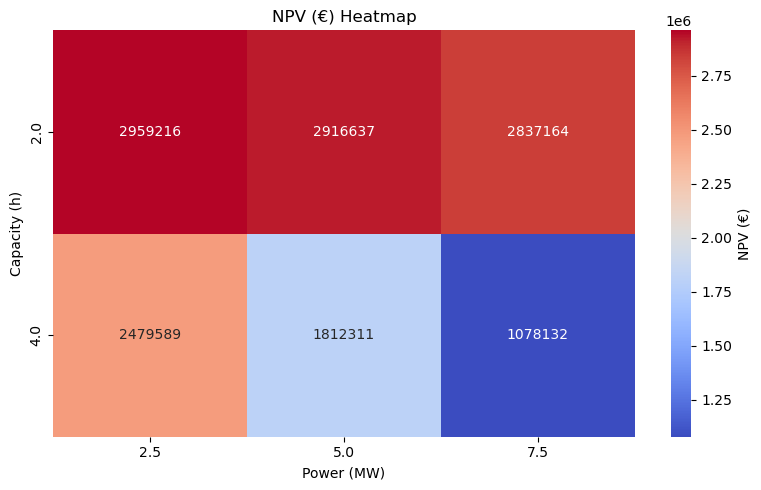

In [14]:
# Plot NPV heatmap
kpi_heatmap(economic_results, kpi="NPV (€)", cmap="coolwarm", decimals=0)

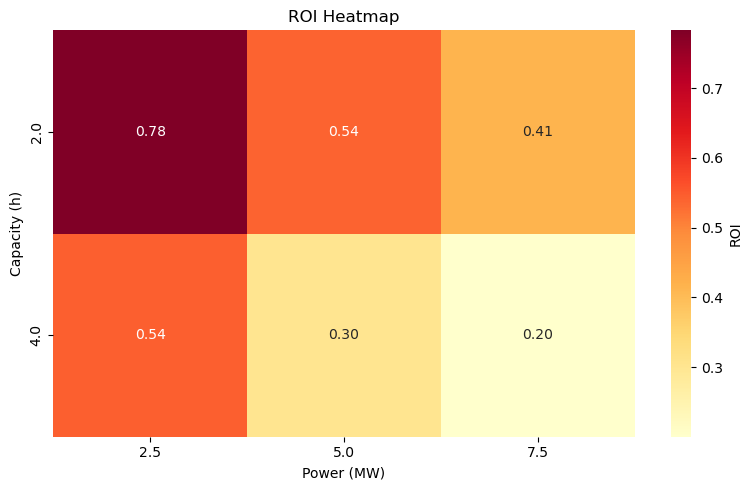

In [15]:
# Plot ROI heatmap
kpi_heatmap(economic_results, kpi="ROI", cmap="YlOrRd", decimals=2)

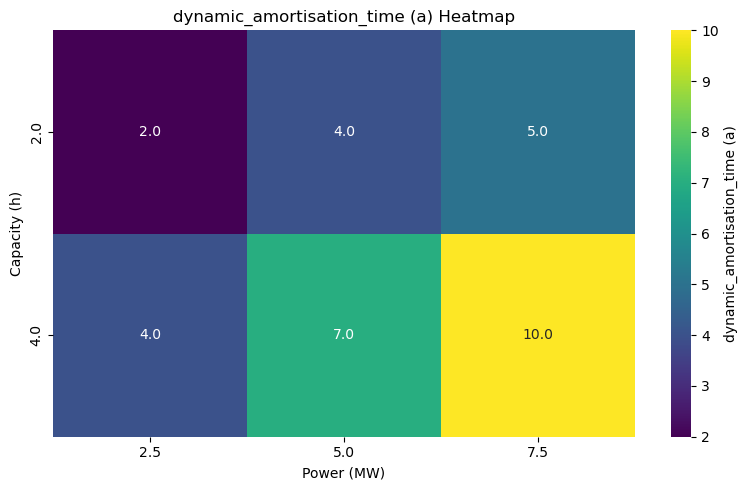

In [16]:
# Plot dynamic amortisation time heatmap
kpi_heatmap(economic_results, kpi="dynamic_amortisation_time (a)", cmap="viridis", decimals=1)

### Saving our economic results as a csv file

In [17]:
economic_results.to_csv('opt/out/economic_results.csv')

## Taking a closer look at our best BESS configuration
We could see from the result of the economic evaluation that the 2.5 MW / 2 h battery is the best option for our system from an economic point of view. We will now investigate the results of its cashflow calculation more closely. 

### Reading the cashflow calculation results

In [18]:
p_best = 2.5
cap_hrs_best = 2.0

df_cashflow_best_option = pd.read_csv(f'opt/out/p_{p_best}_h_{cap_hrs_best}/cashflows.csv', index_col=0)
df_cashflow_best_option

,capex_bess,opex_bess,electricity_profits_sell,electricity_costs_buy,avoided_costs_baseline,total_costs,total_profits,total_cashflow,cumulative_cashflow
2024-12-31,-1250000.0,0.0,336769.427842,-335890.248202,464432.59545,-1.585890e+06,801202.023292,-784688.224911,-7.846882e+05
2025-12-31,0.0,-18750.0,336769.427842,-335890.248202,464432.59545,-3.546402e+05,801202.023292,446561.775089,-3.381264e+05
2026-12-31,0.0,-18750.0,336769.427842,-335890.248202,464432.59545,-3.546402e+05,801202.023292,446561.775089,1.084353e+05
2027-12-31,0.0,-18750.0,336769.427842,-335890.248202,464432.59545,-3.546402e+05,801202.023292,446561.775089,5.549971e+05
2028-12-31,0.0,-18750.0,336769.427842,-335890.248202,464432.59545,-3.546402e+05,801202.023292,446561.775089,1.001559e+06
2029-12-31,0.0,-18750.0,336769.427842,-335890.248202,464432.59545,-3.546402e+05,801202.023292,446561.775089,1.448121e+06
2030-12-31,0.0,-18750.0,336769.427842,-335890.248202,464432.59545,-3.546402e+05,801202.023292,446561.775089,1.894682e+06
2031-12-31,0.0,-18750.0,336769.427842,-335890.248202,464432.59545,-3.546402e+05,801202.023292,446561.775089,2.341244e+06
2032-12-31,0.0,-18750.0,336769.427842,-335890.248202,464432.59545,-3.546402e+05,801202.023292,446561.775089,2.787806e+06
2033-12-31,0.0,-18750.0,336769.427842,-335890.248202,464432.59545,-3.546402e+05,801202.023292,446561.775089,3.234368e+06


### Visualizing the cashflow results

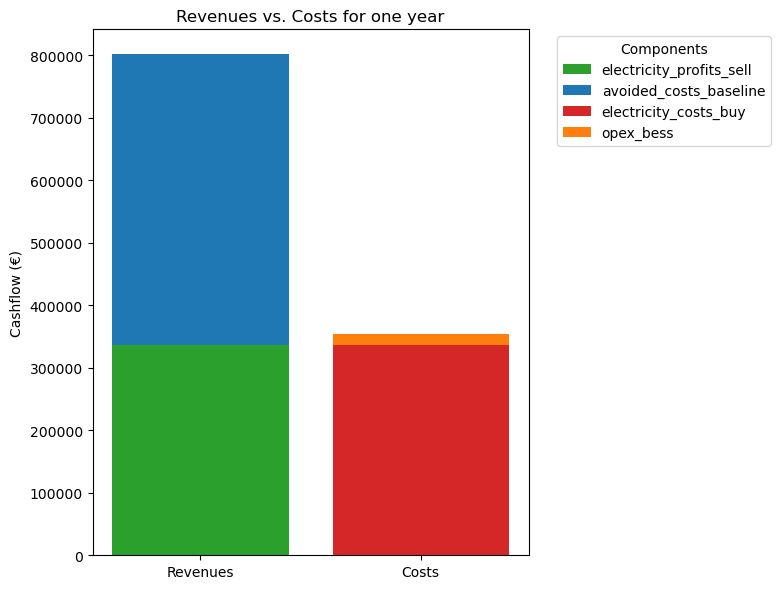

In [19]:
stacked_profit_cost_bar(df_cashflow_best_option)